In [2]:
import time
import json
import ast
import os
import datetime
import io
from collections import defaultdict

import imageio
import boto3
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
import seaborn as sns

from brtdevkit.core.db.athena import AthenaClient
from brtdevkit.data import Dataset
from timezonefinder import TimezoneFinderL
import pytz

from aletheia_dataset_creator.dataset_tools.aletheia_dataset_helpers import imageids_to_dataset
from aletheia_dataset_creator.config.dataset_config import LEFT_CAMERAS, ALL_CAMERA_PAIRS_LIST
%matplotlib inline

/home/alex.li/.conda/envs/cvml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('display.max_rows', 500)
athena = AthenaClient()
s3 = boto3.resource('s3')
tf = TimezoneFinderL()
from pathlib import Path
home = Path(os.path.expanduser('~'))
data_path = home / 'data' / 'dust_dataset'

In [14]:
if os.path.exists(data_path / 'df_sequences.parquet'):
    df_sequences = pd.read_parquet(data_path / 'df_sequences.parquet')
else:
    query = """SELECT ij.id, hard_drive_name, robot_name, collected_on,
        bag_name, operating_field_name, operation_time, latitude, longitude, geohash, camera_location, 
        bundle, group_id, s3_bucket, s3_key, special_notes
    FROM image_jupiter AS ij
    JOIN "image_artifact_jupiter" ON ij."id" = "image_artifact_jupiter"."image"
    WHERE "hard_drive_name" IN ('JUPD-004_2023-7-19', 'JUPD-006_2023-7-19', 'JUPD-007_2023-7-11')
    """
    df_sequences: pd.DataFrame = athena.get_df(query) # type: ignore
    df_sequences.to_parquet(data_path / 'df_sequences.parquet')


In [15]:
df_sequences.iloc[0]

id                                               64bee4dd4010e725e44ceed7
hard_drive_name                                        JUPD-006_2023-7-19
robot_name                                                      loamy_731
collected_on                                   2023-07-14 01:08:43.273000
bag_name                                              07_14_2023-01_08_03
operating_field_name                                              Tract 1
operation_time                                                    daytime
latitude                                                        27.817392
longitude                                                       -97.56502
geohash                                                      9ufw7b5243b0
camera_location                                        front-center-right
bundle                                                               6524
group_id                                 87c504e01ed0471b8e8cb844a1db2888
s3_bucket                             

In [13]:
if os.path.exists(data_path / 'df_dusty.parquet'):
    df_dusty = pd.read_parquet(data_path / 'df_dusty.parquet')
else:
    query = """SELECT ij.id, hard_drive_name, robot_name, collected_on,
        bag_name, operating_field_name, operation_time, latitude, longitude, geohash, camera_location, 
        bundle, group_id, s3_bucket, s3_key
    FROM image_jupiter AS ij
    JOIN "image_artifact_jupiter" ON ij."id" = "image_artifact_jupiter"."image"
    WHERE "hard_drive_name" IN ('JUPD-153_2023-6-29')
    """
    df_dusty: pd.DataFrame = athena.get_df(query) # type: ignore
    df_dusty.to_parquet(data_path / 'df_dusty.parquet')

In [ ]:
# Filter images to debayeredrgb and left camera only

In [7]:
df_sequences.iloc[0]['s3_bucket']

'brt-mesa-jupiter-images-eng'

In [8]:
df_sequences.iloc[0]

id                                               64af9fc7235017ddd0e2725c
hard_drive_name                                        JUPD-153_2023-6-29
robot_name                                                      loamy_731
collected_on                                   2023-06-28 18:32:28.557000
bag_name                                              06_28_2023-18_31_52
operating_field_name                                                     
operation_time                                                    unknown
latitude                                                              0.0
longitude                                                             0.0
geohash                                                      7zzzzzzzzzzz
camera_location                                           side-left-right
bundle                                                               6421
group_id                                 7e58c443353d46aeaa85417c3c7526d6
s3_bucket                             

In [9]:
from brtdevkit.util.aws.s3 import S3
client = S3()

In [10]:
client.download_file('brt-mesa-jupiter-images-eng', '2023/07/18/e4777c3ef4b147c79b224a88a67ed0e0-datapoint_side-right-left_debayeredrgb.png', 'out.png')

True

In [11]:
# OK. First, let's look through these sequences.

In [33]:
df_groups = df_sequences.groupby('special_notes').groups

In [35]:
df_index = df_groups.keys()

In [46]:
k = list(df_index)[12]
print(k)
df = df_sequences.iloc[df_groups[k]]

vehicle dust dusk  29


In [51]:
df = df.sort_values('collected_on')

In [52]:
from datetime import datetime
def get_start_offset_fromtime(cam_day, movie, hour, minute):
    m, d = map(int,cam_day[2].split('/'))
    start_t = datetime(2023, m, d, hour, minute, tzinfo=movie['collected_on_localtime'].iloc[0].tzinfo)
    return (movie['collected_on_localtime'] > start_t).argmax()
img_cache = {}

In [60]:
data_dir = '/mnt/sandbox1/alex.li/cache'
import cv2

In [73]:
# client.download_file('brt-mesa-jupiter-images-eng', '2023/07/18/e4777c3ef4b147c79b224a88a67ed0e0-datapoint_side-right-left_debayeredrgb.png', 'out.png')
b = 'brt-mesa-jupiter-images-eng'
k = '2023/07/24/b89f357733e54a7ea83e1b2f9d99363c-datapoint_front-center-left_raw.tif
client.download_file(b, k, '/mnt/sandbox1/alex.li/cache/vehicle_dust_dusk_29/9.png')

SyntaxError: unterminated string literal (detected at line 3) (23745211.py, line 3)

In [ ]:

        im_path = Path(data_dir) / str(movie_name.replace(' ', '_')) / (str(idx) + '.png')

Watching vehicle dust dusk  29. Total images 28056, viewing 39 starting from 0 with step 10
brt-mesa-jupiter-images-eng
2023/07/24/9933aecae6914a129930eab06c685f71-datapoint_front-right-left_debayeredrgb.png
/mnt/sandbox1/alex.li/cache/vehicle_dust_dusk__29/19.png
brt-mesa-jupiter-images-eng
2023/07/24/c1d3b50668654b328e273e322b0e0c2f-datapoint_front-center-left_raw.tiff
/mnt/sandbox1/alex.li/cache/vehicle_dust_dusk__29/29.png
brt-mesa-jupiter-images-eng
2023/07/24/0fa6209369d74e9caf193d967b0d8895-datapoint_front-left-left_raw.tiff
/mnt/sandbox1/alex.li/cache/vehicle_dust_dusk__29/39.png
brt-mesa-jupiter-images-eng
2023/07/24/3441f2c78208444284a2aab9545fbf68-datapoint_front-right-right_raw.tiff
/mnt/sandbox1/alex.li/cache/vehicle_dust_dusk__29/49.png
brt-mesa-jupiter-images-eng
2023/07/24/105f3323ba664fa8be233d4e0f62209e-datapoint_front-center-right_debayeredrgb.png
/mnt/sandbox1/alex.li/cache/vehicle_dust_dusk__29/59.png
brt-mesa-jupiter-images-eng
2023/07/24/0f31b1c3f048491d99c4595d3

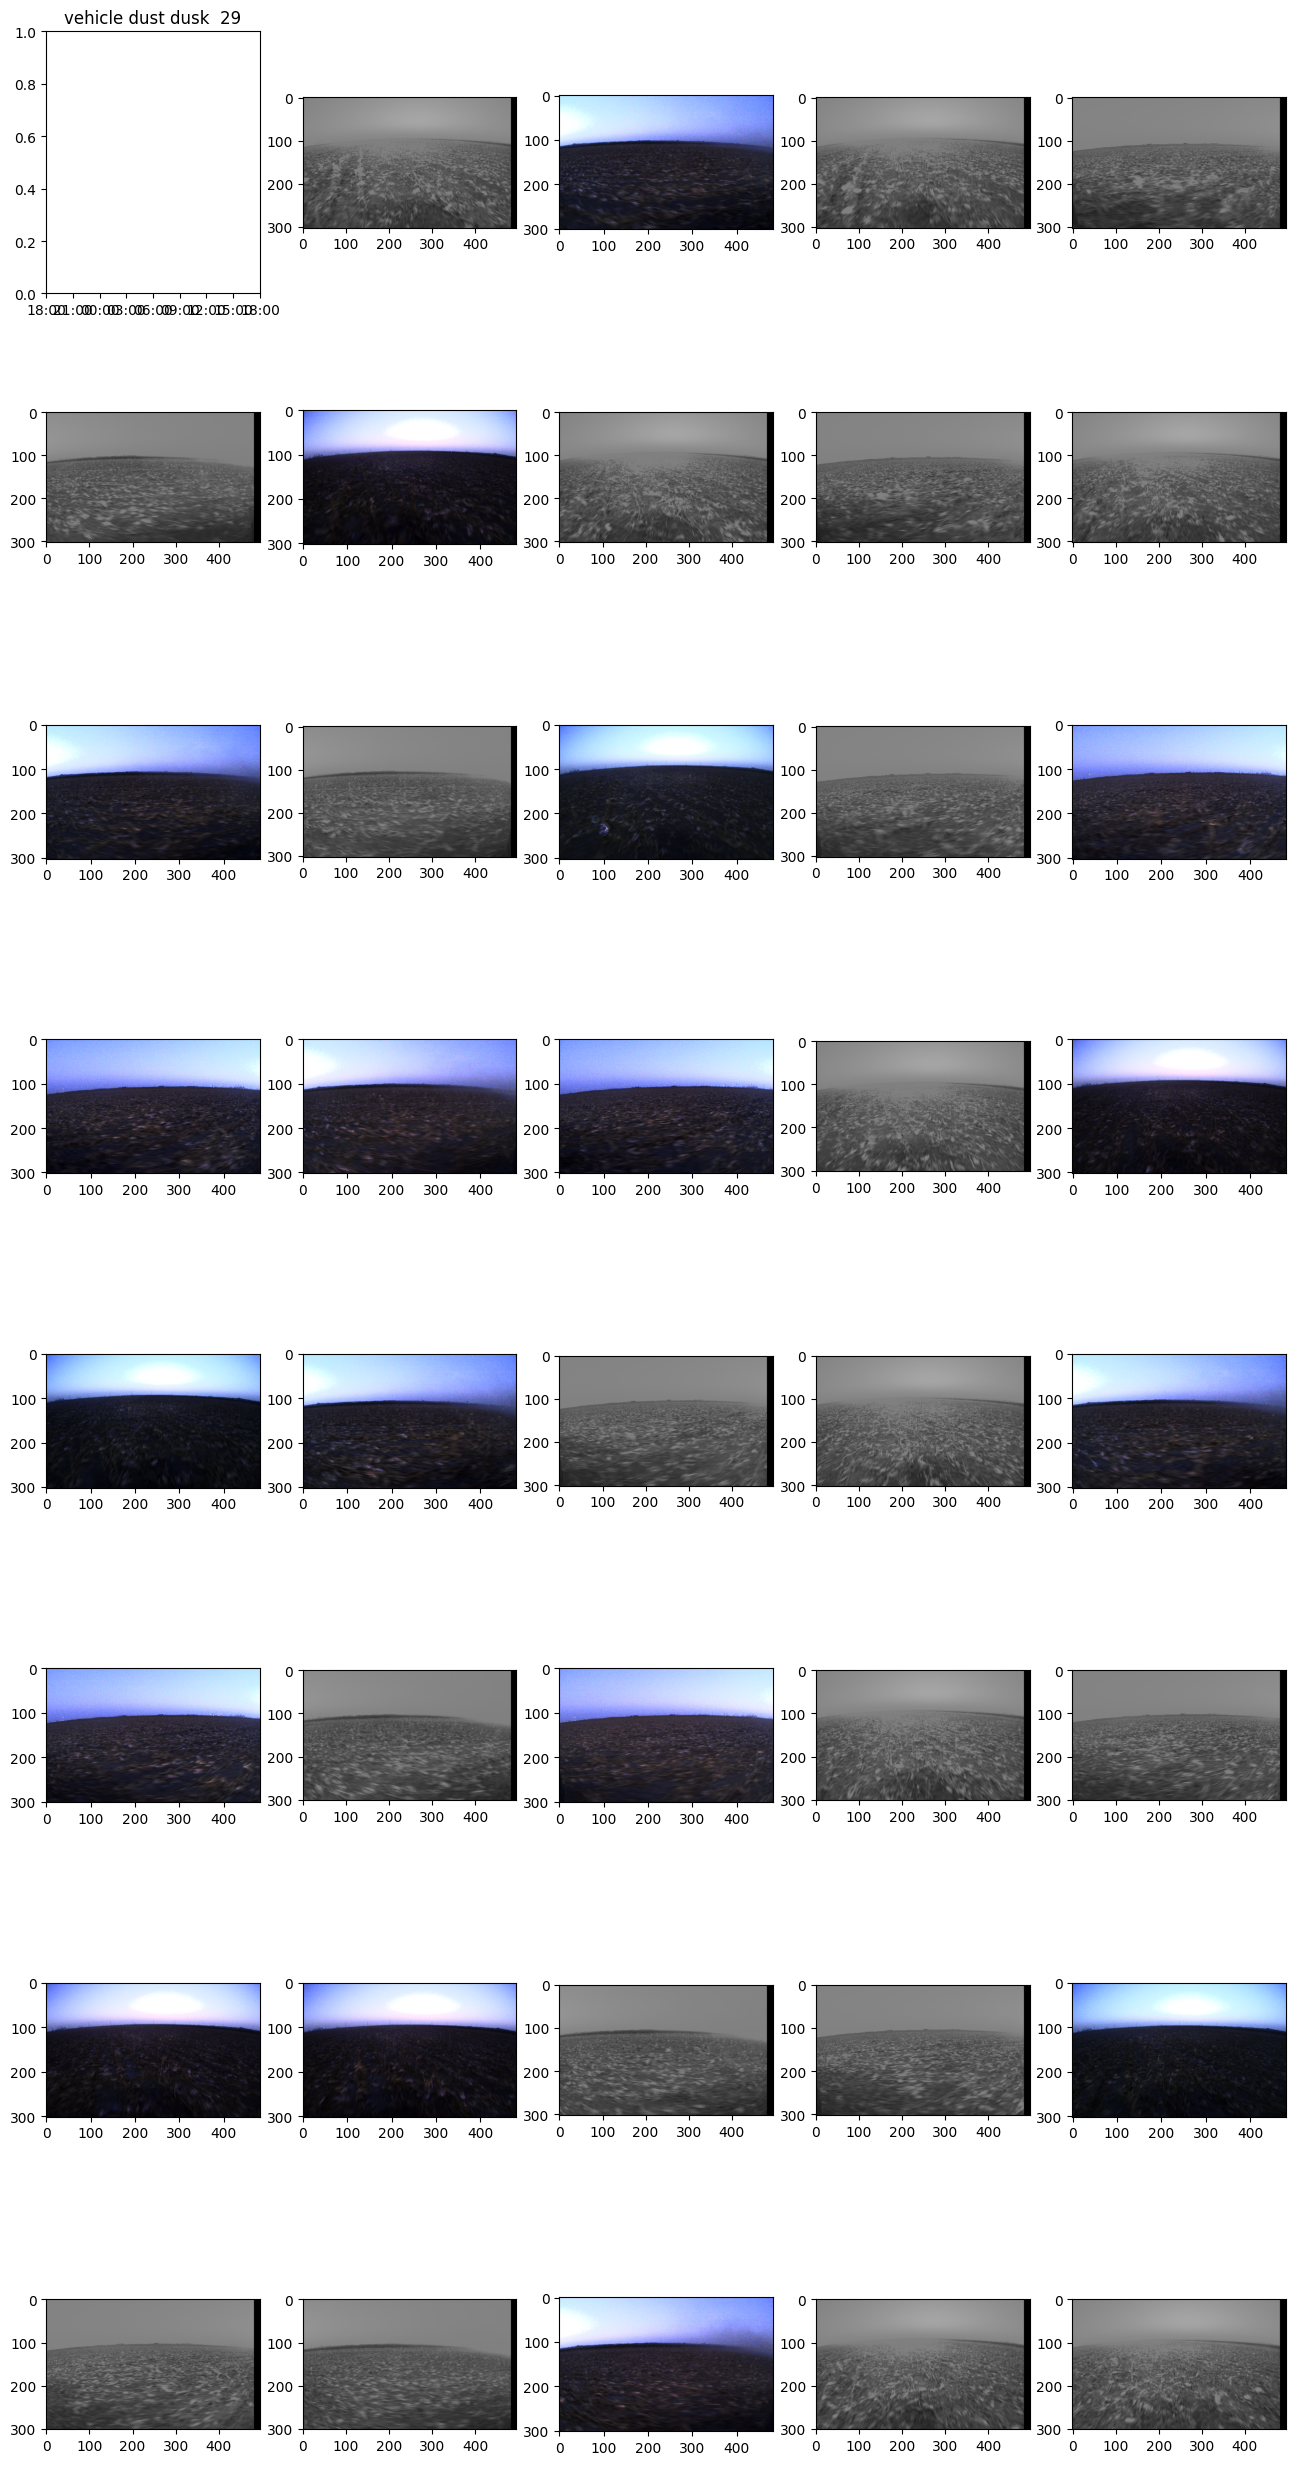

In [78]:
import matplotlib.dates as mdates

def plot(movie_name, movie=None, ncols=20, offset=0, step=1) -> None:
    os.makedirs(Path(data_dir) / str(movie_name.replace(' ', '_')), exist_ok=True)
    if movie is None:
        movie = movie = df.iloc[df_groups[movie_name]].sort_values('collected_on_localtime')
    offset = max(0, min(offset, len(movie) - (ncols - 1) * step))
    print(f"Watching {movie_name}. Total images {len(movie)}, viewing {ncols - 1} starting from {offset} with step {step}")
    rows_per_cat = (4 + ncols) // 5
    nrows = rows_per_cat
    fig, ax = plt.subplots(nrows, 5, figsize=(16, nrows * 4))

    ax0 = ax[0][0]
    ax0.set_title(movie_name)
    tz = tf.timezone_at(lng=movie.iloc[0]['longitude'], lat=movie.iloc[0]['latitude'])
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
    ax0.xaxis.set_major_locator(mdates.HourLocator(interval=3, tz=tz))
    for j in range(1, ncols):
        idx = offset + j * step - 1
        if idx >= len(movie):
            break
        df_row = movie.iloc[idx]
        im_path = Path(data_dir) / str(movie_name.replace(' ', '_')) / (str(idx) + '.png')
        if im_path not in img_cache:
            client.download_file(df_row['s3_bucket'], df_row['s3_key'], im_path)
            img_cache[im_path] = cv2.imread(str(im_path))
        im = img_cache[im_path]
        ax[j // 5][j % 5].imshow(im[::2,::2, ::-1])
        ax[j // 5][j % 5].set_title(f"{df_row['collected_on'] df_row['speed_kph']:.0f}k/h")
ncols = 40 # len(movie) + 1
# offset = 20
step = 10
k = list(df_index)[12]
movie = df_sequences.iloc[df_groups[k]].sort_values('collected_on')
# offset = get_start_offset_fromtime(k, movie, hour=13, minute=25)
# print(offset)
offset = 0
plot(k, movie, ncols, offset, step)